In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Dense, Conv2D, InputLayer, BatchNormalization, Flatten, MaxPooling2D
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy

#### **DATA PREPARATION**

In [36]:
(raw_train, raw_val, raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    as_supervised = True,
    shuffle_files = True,
    split = ['train[:80%]','train[80%:90%]','train[90%:]'],
    with_info = True
)
raw_train

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [34]:
metadata

tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    full_name='cats_vs_dogs/4.0.1',
    description="""
    A large set of images of cats and dogs. There are 1738 corrupted images that are dropped.
    """,
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    data_dir='/root/tensorflow_datasets/cats_vs_dogs/4.0.1',
    file_format=tfrecord,
    download_size=786.67 MiB,
    dataset_size=1.04 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    splits={
        'train': <SplitInfo num_examples=23262, num_shards=16>,
    },
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, Jo

In [33]:
for data in raw_train:
  print(data)  # raw_train is a collection of tuples
  break
# max value of any row or column in any image is 500.
# It would be best to resize each and every image to 500.

(<tf.Tensor: shape=(194, 179, 3), dtype=uint8, numpy=
array([[[110, 106,  94],
        [ 99,  95,  83],
        [ 88,  84,  72],
        ...,
        [ 68,  48,  21],
        [ 76,  56,  29],
        [ 84,  64,  37]],

       [[101,  97,  85],
        [ 91,  87,  75],
        [ 83,  79,  67],
        ...,
        [ 83,  62,  35],
        [ 84,  64,  37],
        [ 84,  64,  37]],

       [[ 90,  86,  74],
        [ 83,  79,  67],
        [ 77,  73,  61],
        ...,
        [ 81,  59,  35],
        [ 82,  60,  36],
        [ 84,  62,  38]],

       ...,

       [[218, 215, 196],
        [218, 215, 196],
        [218, 215, 196],
        ...,
        [ 53,  49,  38],
        [ 47,  45,  32],
        [ 43,  41,  28]],

       [[220, 217, 200],
        [220, 217, 200],
        [220, 217, 200],
        ...,
        [ 47,  43,  32],
        [ 48,  44,  33],
        [ 49,  45,  34]],

       [[220, 217, 200],
        [220, 217, 200],
        [220, 217, 200],
        ...,
        [ 49,  45,  

#### **DATA VISUALIZATION**

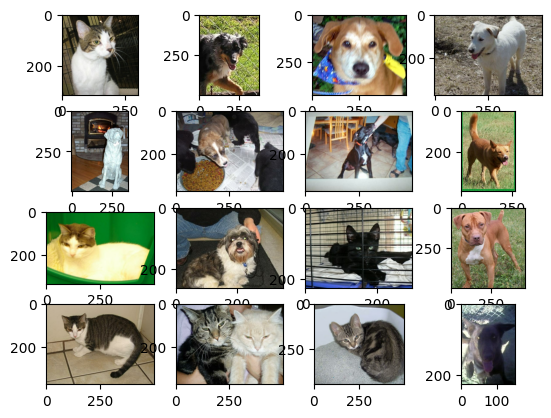

In [3]:
for i, (image,label) in enumerate(raw_train.take(16)):
  ax = plt.subplot(4,4,i+1)
  plt.imshow(image)

#### **DATA PREPROCESSING**

In [37]:
IM_SIZE = 250
def resize_rescale(image,label): # <-- Note: the parameters that are taken in a way that it expects images and labels seperately.
  return tf.image.resize(image,(IM_SIZE,IM_SIZE))/255, label

In [38]:
train_dataset = raw_train.map(resize_rescale) # The images and labels are passed seprately in the function as we can see from the syntax
print([i for i in train_dataset.take(1)])

[(<tf.Tensor: shape=(250, 250, 3), dtype=float32, numpy=
array([[[0.99470925, 0.99470925, 0.99470925],
        [0.9876818 , 0.9876818 , 0.9876818 ],
        [0.98760784, 0.98760784, 0.98760784],
        ...,
        [0.99032116, 0.99032116, 0.99032116],
        [0.9813681 , 0.9813681 , 0.9813681 ],
        [0.99453175, 0.99453175, 0.99453175]],

       [[0.98423976, 0.98423976, 0.98423976],
        [0.94663984, 0.94663984, 0.94663984],
        [0.9481176 , 0.9481176 , 0.9481176 ],
        ...,
        [0.94244826, 0.94244826, 0.94244826],
        [0.94800425, 0.94800425, 0.94800425],
        [0.98196834, 0.98196834, 0.98196834]],

       [[0.98567843, 0.98567843, 0.98567843],
        [0.94255924, 0.94255924, 0.94255924],
        [0.9113393 , 0.9113393 , 0.9113393 ],
        ...,
        [0.9127489 , 0.9127489 , 0.9127489 ],
        [0.94141245, 0.94141245, 0.94141245],
        [0.9852233 , 0.9852233 , 0.9852233 ]],

       ...,

       [[0.98357683, 0.9874984 , 0.96789056],
        [0.

In [39]:
val_dataset = raw_val.map(resize_rescale)
test_dataset = raw_val.map(resize_rescale)

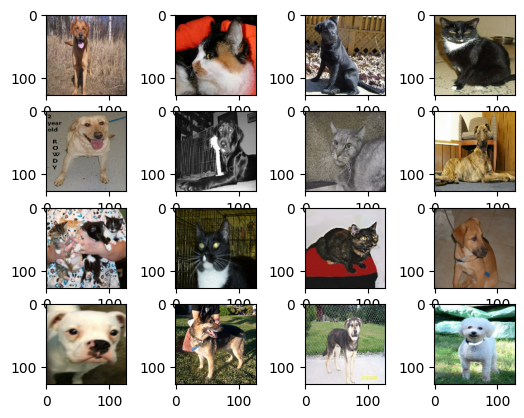

In [17]:
# what if now we try to plot the images?
for i, (image,label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4,4,i+1)
  plt.imshow(image) # we see that the plot or images are shown as before only.

In [40]:
train_dataset = train_dataset.shuffle(buffer_size = 512, reshuffle_each_iteration = True).batch(32).prefetch(tf.data.AUTOTUNE)
train_dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 250, 250, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [41]:
val_dataset = val_dataset.shuffle(buffer_size = 512, reshuffle_each_iteration = True).batch(16)
test_dataset = test_dataset.shuffle(buffer_size = 512, reshuffle_each_iteration = True).batch(16)

In [42]:
val_dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 250, 250, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

#### **MODEL PREPARATION**

In [58]:
model = tf.keras.Sequential([
    InputLayer(shape = (250,250,3)),

    Conv2D(filters = 6,kernel_size = 3,strides = 1,activation = 'relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size = 2,strides = 2),

    Conv2D(filters = 16,kernel_size = 4,strides = 1, activation = 'relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size = 2,strides = 2),

    # Conv2D(filters = 128,kernel_size = 2,strides = 1, activation = 'relu'),
    # BatchNormalization(),
    # MaxPooling2D(pool_size = 2,strides = 1),

    Flatten(),

    Dense(80,activation = 'relu'),
    BatchNormalization(),
    Dense(20, activation = 'relu'),
    BatchNormalization(),
    Dense(1,activation = 'sigmoid')
])
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_28 (Conv2D)              │ (None, 248, 248, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_50          │ (None, 248, 248, 6)    │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 124, 124, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 121, 121, 16)   │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_51          │ (None, 121, 121, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 60, 60, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 80)             │     4,608,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_52          │ (None, 80)             │           320 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 20)             │         1,620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_53          │ (None, 20)             │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,611,929 (17.59 MB)

 Trainable params: 4,611,685 (17.59 MB)

 Non-trainable params: 244 (976.00 B)

In [59]:
model.compile(
    optimizer = Adam(learning_rate = 0.001),
    loss = BinaryCrossentropy(),
    metrics = ['accuracy']
)

#### **MODEL TRAINING**

In [ ]:
history = model.fit(train_dataset,validation_data = val_dataset,epochs = 8,verbose = 1)

Epoch 1/8
582/582 ━━━━━━━━━━━━━━━━━━━━ 49s 68ms/step - accuracy: 0.6417 - loss: 0.6487 - val_accuracy: 0.6827 - val_loss: 0.5953
Epoch 2/8
582/582 ━━━━━━━━━━━━━━━━━━━━ 38s 64ms/step - accuracy: 0.7561 - loss: 0.4942 - val_accuracy: 0.7115 - val_loss: 0.6061
Epoch 3/8
582/582 ━━━━━━━━━━━━━━━━━━━━ 37s 62ms/step - accuracy: 0.8427 - loss: 0.3536 - val_accuracy: 0.7352 - val_loss: 0.5813
Epoch 4/8
582/582 ━━━━━━━━━━━━━━━━━━━━ 41s 62ms/step - accuracy: 0.9235 - loss: 0.1932 - val_accuracy: 0.7541 - val_loss: 0.6993
Epoch 5/8
582/582 ━━━━━━━━━━━━━━━━━━━━ 36s 61ms/step - accuracy: 0.9576 - loss: 0.1124 - val_accuracy: 0.7459 - val_loss: 0.7971
Epoch 6/8
582/582 ━━━━━━━━━━━━━━━━━━━━ 41s 61ms/step - accuracy: 0.9702 - loss: 0.0803 - val_accuracy: 0.7438 - val_loss: 0.8928
Epoch 7/8
582/582 ━━━━━━━━━━━━━━━━━━━━ 35s 59ms/step - accuracy: 0.9798 - loss: 0.0626 - val_accuracy: 0.7472 - val_loss: 0.9167
Epoch 8/8
582/582 ━━━━━━━━━━━━━━━━━━━━ 35s 58ms/step - accuracy: 0.9843 - loss: 0.0460 - val_accu